In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import random 

pi = np.pi
print("imports work")


imports work


Define qubit and gates as matrices

In [3]:
# expressing the relation between qbit and its matrix
def quvec(a):
    exp = 0
    b = np.zeros([2**len(a)])
    for i in range(len(a)):
        exp += (a[-i-1])*(2**i) # -i-1 gives the values from the end of the array
    b[-exp-1] = 1
    return b


In [4]:
#correct base Ket
# define the base for a vector represntation of qubit
def ket_base(index, L):
    n = int(np.log2(L))
    b = np.zeros(n)
    for i in range(n):
        b[-i-1] = index % 2
        index = index//2
    return b

# print the base as kets
def as_string_index(index, L):
    ket = [str(int(i)) for i in ket_base(index, L)]
    return f"|{','.join(ket)}>"

# print the components of a vector in the base presentation
def ket(psi):
    kets = [as_string_index(i, len(psi)) for i in range(len(psi))]
    return [' + '.join([f'{psi[i]} {kets[-i-1]}' for i in range(len(psi)) if psi[i] != 0])]


In [5]:
# 1_Bit operators and important states
# Pauli
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
I = np.array([[1,0],[0,1]])

# Clifford
H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
S = np.array([[1j,0],[0,-1j]])
T = np.array([[1,0],[0,np.exp((1j*pi)/4)]])

# X base
plus = (quvec([0]) + quvec([1]))/np.sqrt(2)
minus = (quvec([0]) - quvec([1]))/np.sqrt(2)

# bell states



Operate gates on states

In [6]:
# function to operate gates a series of gates on a state
def operate(operators, psi):
    vec_psi = quvec(psi)
    for i in range(len(operators)):
        vec_psi = np.matmul(operators[-i-1], vec_psi)
    return vec_psi

In [7]:
# creat n dimension gates
def n_d_gates(operators):
    gate = operators[-1]
    for i in range(len(operators)-1):
        gate = np.kron(operators[-i-2],gate)
    return gate


In [8]:
# apply general operators on a general qubit
def matrix_gate(gates,quvec): # gates is a list of gates and theis indices, 
                              # i.e [X,1,Y,3] will perform the tensor products for X in 1 and Y in 3 while the rest are I matching to the state dimension
    
    init_gate = [I]*(int(np.log2(len(quvec))))
    i = 1
    while i <= len(gates):
        init_gate[gates[i]-1] = gates[i-1]
        i += 2
    final_gate = n_d_gates(init_gate)
    return final_gate
    
    


def general_operate(gates,quvec): # gates is a list of gates and theis indices, i.e [X,1,Y,3] will apply X on the 1st qubit and Y on the 3rd
    # the first qubit index is 1
    final_gate = matrix_gate(gates,quvec)
    a = np.matmul(final_gate,quvec)
    return a

In [9]:
psi = [1,0,0,1,0,0]
psi_1 = general_operate([Z,1,X,3], quvec(psi))
print ("psi_1 =", ket(psi_1))


psi_1 = ['1.0 |1,0,1,1,0,0>']


Normalization, probability density and power tesnor product

In [10]:
# normalize a state
def norm(qvec):
    qvec_size = np.matmul(np.conj(qvec),qvec)
    normalized_state = (qvec)/np.sqrt(qvec_size)
    return normalized_state

#8 this function takes a state in superposition of base vectors and return only one, considering probabilities
def measure_probability(state):       # state should be an array - vector
    final_state = np.zeros(len(state))
    outcomes = list(range(0,len(state)))
    probabilities = norm(state)
    measurment = random.choices(outcomes, weights=probabilities, k=1)
    final_state[measurment[0]] = 1
    return final_state

    

In [11]:
# tensor product a tensor with himself multiple times

def tensor_exponent(tensor,power):
    i = 1
    if power != 0:
        power_tensor = tensor
        while i < power:
            power_tensor = np.kron(tensor, power_tensor)
            i += 1
    else:
        power_tensor = 1
    return power_tensor




Measurements

In [12]:
# working measurement for 1 qbit system

def observation_value(operator, state): #for pauli, observation ranges between -1 and 1 due to eigenvalues
    a = norm(state)
    b = np.matmul(operator,a) # O|v>
    c = np.conj(a) # <v|
    d = np.round(np.matmul(c,b), 10) # <v|O|v>, rounding is for values close to zero to be zero
    return d

def projector(operator, eigenvalue):
    proj = (I + eigenvalue * operator)/2
    return proj
    
    
def Measure_2d(operator, state):
    state = norm(state)
    p = (observation_value(operator,state) + 1)/2 # Changes <O> range from {-1,1} to {0,1}
    eigenvalue = random.choices([1,-1], cum_weights = [p,1], k = 1)
    proj = projector(operator, eigenvalue)
    return norm(np.matmul(proj, state)) , np.real(p)




In [13]:
int(np.log2(len(quvec([1]))))

1

In [14]:
def Measure(operator, state, site): #first qubit is i = 1
    dimension = int(np.log2(len(state)))
    operator_site = [I]*(site-1) + [operator] + [I]*(dimension-site) #operator list for O in the site place 
    operator_n = n_d_gates(operator_site) # operator of O in the site place, for all the other sites its identity 

    p = (observation_value(operator_n,state) + 1)/2 # Changes <O> range from {-1,1} to {0,1}
    eigenvalue = random.choices([1,-1], cum_weights = [p,1], k = 1)
    
    proj_1d = projector(operator, eigenvalue) # define the 2d projector based on the chosen eigenvalue
    proj = n_d_gates([I]*(site-1) + [proj_1d] + [I]*(dimension-site)) # create operator to project on the wanted site
    return norm(np.matmul(proj, state)) , np.real(p), 1-np.real(p)


In [15]:
# v = norm(quvec([1,1,0,1,0])+quvec([1,0,0,0,0]))
# v = norm(quvec([1,1,0,1,0]))

v = norm(quvec([1]))
a, b ,c = Measure(X,minus,1)
print("measured:",ket(a),"\n""probability for +:", b ,"\n""probability for -:", c)



measured: ['-0.7071067811865476 |1> + 0.7071067811865476 |0>'] 
probability for +: 0.0 
probability for -: 1.0


In [16]:
def measure_simultaneously(measureables, state): #measureables are operators and sites. i.e [X,1,Y,3]
    state = norm(state) #  normalize the input state
    dimension  = int(np.log2(len(state)))
    
    #create the matrix of the wanted measurables
    O = matrix_gate(measureables,state)
    
    # calculate the observation value
    expectation = observation_value(O,state) 

    #probability and choose eigenvalue
    p = (expectation + 1)/2
    eigenvalue = random.choices([1,-1], cum_weights = [p,1], k = 1) #choose +1 or -1 biased by p
    
    #project the state on the chosen eigenvalue subspapce
    projector = (tensor_exponent(I,dimension) + eigenvalue*O)/2  #create the projector
    Projected = np.matmul(projector,state) 
    return norm(Projected), p, eigenvalue
    
    



Histogram of the measurements

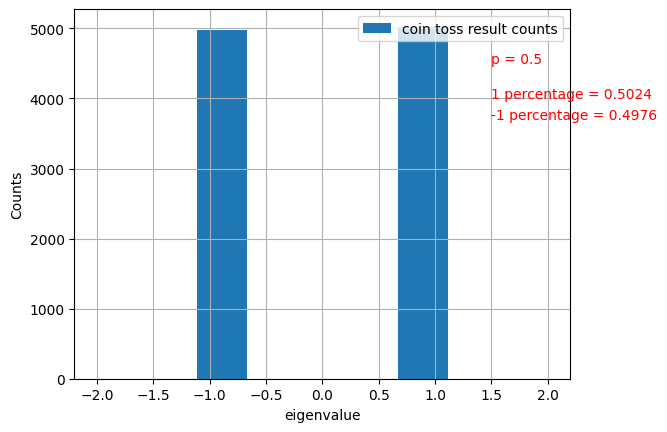

In [17]:
# Histogram for the outcomes of option 1
runs = 10000

a = 1
b = -1
c = 0
d = 0

psi = a*quvec([1,0])+ b*quvec([0,1])+ c*quvec([0,0])+ d*quvec([1,1])
gates = [Z,1]

site = []
bins = np.linspace(-2, 2, 10)
for i in range(runs):
    measured, p, eigenvalue  = measure_simultaneously(gates,psi)
    site.append(eigenvalue)



site = sum(site,[])
ratio1 = (np.histogram(site,bins = 2)[0][1])/runs
ratio2 = (np.histogram(site,bins = 2)[0][0])/runs

plt.hist([site], bins, label=['coin toss result counts'])
plt.text(1.5, 4500, f'p = {p}', fontsize=10, color='red')
plt.text(1.5, 4000, f'1 percentage = {ratio1}', fontsize=10, color='red')
plt.text(1.5, 3700, f'-1 percentage = {ratio2}', fontsize=10, color='red')
plt.legend(loc='upper right')
plt.xlabel("eigenvalue")
plt.ylabel("Counts")
plt.grid()
plt.show()

In [18]:
a = 1
b =1
c = 0
d = 0

v = a*quvec([1,1,1]) + b*quvec([0,1,0]) + c*quvec([1,1,0])+ d*quvec([0,0,0])
state = a*quvec([1,1,1])+b*quvec([1,1,0]) + c*quvec([1,0,1]) + d*quvec([0,0,1]) + quvec([0,1,0]) + quvec([1,0,0])
measurables = [X,1,X,2]


# measured, p, eigenvalue = measure_simultaneously2(measurables,state)
measured, p, eigenvalue = measure_simultaneously(measurables,v)

print('measured:', ket(measured), '\n probability for +1:', p, '\n eigenvalue:', eigenvalue)

measured: ['0.5 |1,1,1> + 0.5 |1,0,0> + 0.5 |0,1,0> + 0.5 |0,0,1>'] 
 probability for +1: 0.5 
 eigenvalue: [1]


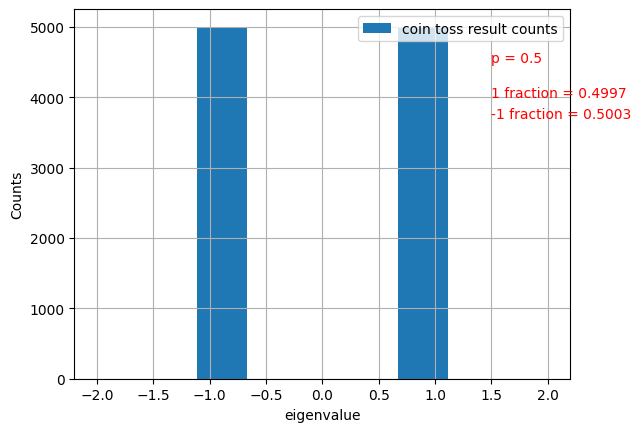

In [19]:
# Histogram for the outcomes of option 1
# define the amount of runs, the state and the measurement operator
runs = 10000

a = 1
b = 1
c = 1
d = 1

state = a*quvec([1,1,1]) + b*quvec([0,1,0]) + c*quvec([1,0,1]) + d*quvec([0,0,0])
measurables = [X,1,X,2]


#create the data for the histogram
site = []
for i in range(runs):
    # a, b, eigenvalues, probabilities, e, f  = measure_simultaneously([Z,1,X,2],quvec([1,1]))
    measured, p, eigenvalue  = measure_simultaneously(measurables,state)
    site.append(eigenvalue)


site = sum(site,[])
ratio1 = (np.histogram(site,bins = 2)[0][1])/runs
ratio2 = (np.histogram(site,bins = 2)[0][0])/runs

# print the histogram
bins = np.linspace(-2, 2, 10)
plt.hist([site], bins, label=['coin toss result counts'])
plt.text(1.5, 4500, f'p = {p}', fontsize=10, color='red')
plt.text(1.5, 4000, f'1 fraction = {ratio1}', fontsize=10, color='red')
plt.text(1.5, 3700, f'-1 fraction = {ratio2}', fontsize=10, color='red')
plt.legend(loc='upper right')
plt.xlabel("eigenvalue")
plt.ylabel("Counts")
plt.grid()
plt.show()

Measurments of non commutive operators

In [20]:
def Measure_Z_for_entire_state_uniform_probability(state, probability):
    state = norm(state)
    dimension = int(np.log2(len(state)))
    p = random.choices([1,-1], cum_weights = [probability,1], k = dimension) #choose +1 or -1 biased by p
    sites_measured = []
    for i in range(1,dimension+1):
        if p[i-1] == 1:
            a,b,c = Measure(Z, state, i) # Measure returns three results: the Measured state(a), probability for +1(b) and prob for -1(c) 
            state = a
            sites_measured.append(i)
    return norm(state), sites_measured

def Measure_XX_for_entire_state_uniform_probability(state,probability):
    state = norm(state)
    dimension = int(np.log2(len(state)))
    p = random.choices([1,-1], cum_weights = [probability,1], k = dimension) #choose +1 or -1 biased by p
    sites_measured = []
    for i in range(1,dimension):
        if p[i-1] == 1:
            a,b,c = measure_simultaneously([X,i,X,i+1], state) #returns three results: normalized Measured state(a), probability for +1(b) chosen eigenvalue(c) 
            state = a
            sites_measured.append(i)
    return norm(state), sites_measured


def sequence_uniform_probability(state,probability, runs):
    Pz = probability
    Px = 1 - probability
    state = norm(state)
    for i in range(1,runs+1):
        # measure Z on each site
        state, sites_measured = Measure_Z_for_entire_state_uniform_probability(state, Pz)
        print(f"state after {i} Z:", ket(state), f", sites_measured for Z {i}:" , sites_measured)

        # measure XX on each neighboring sites
        state, sites_measured = Measure_XX_for_entire_state_uniform_probability(state,Px)
        print(f"state after {i} XX:",ket(state), f" \n sites_measured for XX {i}:" , sites_measured)
    return norm(state)



In [21]:
ket(sequence_uniform_probability(quvec([1,0,0]), 0.9, 3))

state after 1 Z: ['1.0 |1,0,0>'] , sites_measured for Z 1: [1, 2, 3]
state after 1 XX: ['1.0 |1,0,0>']  
 sites_measured for XX 1: []
state after 2 Z: ['1.0 |1,0,0>'] , sites_measured for Z 2: [1, 2, 3]
state after 2 XX: ['0.7071067811865476 |1,1,1> + 0.7071067811865476 |1,0,0>']  
 sites_measured for XX 2: [2]
state after 3 Z: ['1.0 |1,0,0>'] , sites_measured for Z 3: [1, 2, 3]
state after 3 XX: ['1.0 |1,0,0>']  
 sites_measured for XX 3: []


['1.0 |1,0,0>']

In [22]:
def Measure_Z_for_entire_state(state, probabilities):
    p = np.array(probabilities)
    norm_p = p/sum(p)
    state = norm(state)
    dimension = int(np.log2(len(state)))
    sites_measured = []
    for i in range(1,dimension+1):
        p = random.choices([1,-1], cum_weights = [norm_p[i-1],1], k = 1) #choose +1 or -1 biased by p
        if p[0] == 1:
            a,b,c = Measure(Z, state, i) # Measure returns three results: the Measured state(a), probability for +1(b) and prob for -1(c) 
            state = a
            sites_measured.append(i)
    return norm(state), sites_measured

def Measure_XX_for_entire_state(state,probabilities):
    prob = np.array(probabilities)
    norm_p = prob/sum(prob) #make sure the sum of probabilities is 1
    state = norm(state)
    dimension = int(np.log2(len(state)))
    sites_measured = []
    for i in range(1,dimension):
        p = random.choices([1,-1], cum_weights = [norm_p[i-1],1], k = 1) #choose +1 or -1 biased by p
        if p[0] == 1:
            a,b,c = measure_simultaneously([X,i,X,i+1], state) #returns three results: normalized Measured state(a), probability for +1(b) chosen eigenvalue(c) 
            state = a
            sites_measured.append(i)
    return norm(state), sites_measured




def Z_XX(state, probabilities, runs):
    prob = np.array(probabilities)
    norm_p = prob/sum(prob)
    for i in range(1,runs+1):
        # measure Z on each site
        state, sites_measured = Measure_Z_for_entire_state(state, norm_p)
        print(f"state after {i} Z:", ket(state), f", sites_measured for Z {i}:" , sites_measured)

        # measure XX on each neighboring sites
        state, sites_measured = Measure_XX_for_entire_state(state,norm_p)
        print(f"state after {i} XX:",ket(state), f" \n sites_measured for XX {i}:" , sites_measured)
    return ket(norm(state))





In [23]:
norm_p = [0.1,0.5,0.8]

p = random.choices([1,-1], cum_weights = [norm_p[1],1], k = 1) #choose +1 or -1 biased by p
p

[-1]

In [24]:
Z_XX(quvec([1,0,0]), [1,1,9], 3)

state after 1 Z: ['1.0 |1,0,0>'] , sites_measured for Z 1: [3]
state after 1 XX: ['1.0 |1,0,0>']  
 sites_measured for XX 1: []
state after 2 Z: ['1.0 |1,0,0>'] , sites_measured for Z 2: [3]
state after 2 XX: ['1.0 |1,0,0>']  
 sites_measured for XX 2: []
state after 3 Z: ['1.0 |1,0,0>'] , sites_measured for Z 3: [3]
state after 3 XX: ['1.0 |1,0,0>']  
 sites_measured for XX 3: []


['1.0 |1,0,0>']

Entanglement entropy

In [25]:
def coefficient_matrix(state, division_qubit): #state should be ket, division is the last qubit we want at system a of |a,b>
    dimension = len(state)
    size = dimension / 2**division_qubit
    psi_matrix = np.reshape(state, (-1, int(size)))
    return psi_matrix


In [26]:
v = quvec([0,0,1]) + quvec([0,1,0])
v

array([0., 0., 0., 0., 0., 1., 1., 0.])

In [27]:
v_matrix = coefficient_matrix(v,2)
v_matrix

array([[0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.]])

In [28]:
def entanglement_entropy(state,division):
    state = norm(state)
    psi_matrix = coefficient_matrix(state, division)
    singular_Values = np.linalg.svd(psi_matrix, full_matrices=False, compute_uv=False, hermitian=False)
    S = 0
    for i in singular_Values:
        if i != 0:
            S -= i**2 * np.log(i**2)
    
    # S = [(i**2 * np.log(i**2)) for i in singular_Values]
    return S

In [29]:
entanglement_entropy(v,2)

0.6931471805599454

Ln(2) = 0.6931

In [30]:
entanglement_entropy(v,1)

0.0

In [31]:
a = 1
b = 1
c = 1

v = a*quvec([0,0,0,0]) + b*quvec([1,1,1,1]) + c*quvec([0,0,1,1])
v = norm(v)



print(v, "\n" , coefficient_matrix(v,1))
entanglement_entropy(v, 1)

[0.57735027 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.57735027 0.         0.         0.57735027] 
 [[0.57735027 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.57735027 0.
  0.         0.57735027]]


0.6365141682948128

In [32]:
def Z_XX_uniform_probability(state,probability, runs, division, evolution = True):
    Pz = probability
    Px = 1 - probability
    state = norm(state)
    S_0 =  entanglement_entropy(state,division)
    Entanglement = [S_0]
    if evolution:
        print("Initial Entanglement Entropy:", S_0)
    for i in range(1,runs+1):
        # measure Z on each site
        state, sites_measured = Measure_Z_for_entire_state_uniform_probability(state, Pz)
        S = entanglement_entropy(state,division)
        if evolution:
            print(f"state after {i} Z:", ket(state), f", sites_measured for Z {i}:" , sites_measured, "\n Entanglement entropy:", S)

        # measure XX on each neighboring sites
        state, sites_measured = Measure_XX_for_entire_state_uniform_probability(state,Px)
        S = entanglement_entropy(state,division)
        if evolution:
            print(f"state after {i} XX:",ket(state), f" sites_measured for XX {i}:" , sites_measured,  "\n Entanglement entropy:", S)
        Entanglement.append(S)
    return norm(state) , Entanglement

a,b = Z_XX_uniform_probability(quvec([1,0,0]), 0.5, 3, 1)
print("final state:", ket(a) , "\n entanglement after each run:" , b)


Initial Entanglement Entropy: 0.0
state after 1 Z: ['1.0 |1,0,0>'] , sites_measured for Z 1: [3] 
 Entanglement entropy: 0.0
state after 1 XX: ['1.0 |1,0,0>']  sites_measured for XX 1: [] 
 Entanglement entropy: 0.0
state after 2 Z: ['1.0 |1,0,0>'] , sites_measured for Z 2: [] 
 Entanglement entropy: 0.0
state after 2 XX: ['0.5 |1,1,1> + 0.5 |1,0,0> + 0.5 |0,1,0> + 0.5 |0,0,1>']  sites_measured for XX 2: [1, 2] 
 Entanglement entropy: 0.6931471805599452
state after 3 Z: ['1.0 |0,1,0>'] , sites_measured for Z 3: [1, 3] 
 Entanglement entropy: 0.0
state after 3 XX: ['0.7071067811865476 |0,1,0> + -0.7071067811865476 |0,0,1>']  sites_measured for XX 3: [2] 
 Entanglement entropy: -4.440892098500627e-16
final state: ['0.7071067811865476 |0,1,0> + -0.7071067811865476 |0,0,1>'] 
 entanglement after each run: [0.0, 0.0, 0.6931471805599452, -4.440892098500627e-16]


In [33]:
v = quvec([1,0,1,1]) + quvec([1,1,0,0]) + quvec([1,0,0,0])
P = 0.5
runs = 10
div = 1

S_0 =  entanglement_entropy(v,div)
S_0

0.0

Plot Entanglment Entropy

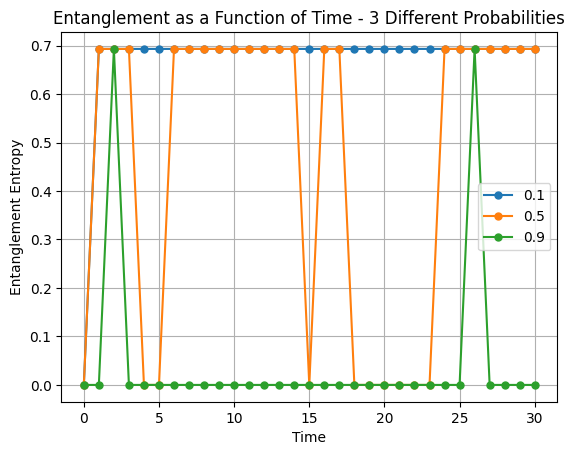

In [36]:
#Entanglement as function of time for different probabilities

# System Settings
v = quvec([1,0,1,0])
# v = quvec([1,0,1,1]) + quvec([1,1,0,0]) + quvec([1,0,0,0])
P = [0.1,0.5,0.9]
runs = 30
div = 2

for p in P:
    # extract the Data 
    final_state, Entanglement = Z_XX_uniform_probability(v, p, runs, div, evolution=False)
    time = np.arange(len(Entanglement))
    # print(Entanglement, time)
    plt.plot(time, Entanglement, marker = '.', markersize = 10, label = f'{p}')


plt.title('Entanglement as a Function of Time - 3 Different Probabilities')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.show()




# #Save plot as PNG file
# output_file = os.path.join(output_folder, f"{sheet_name}.png")
# plt.savefig(output_file)



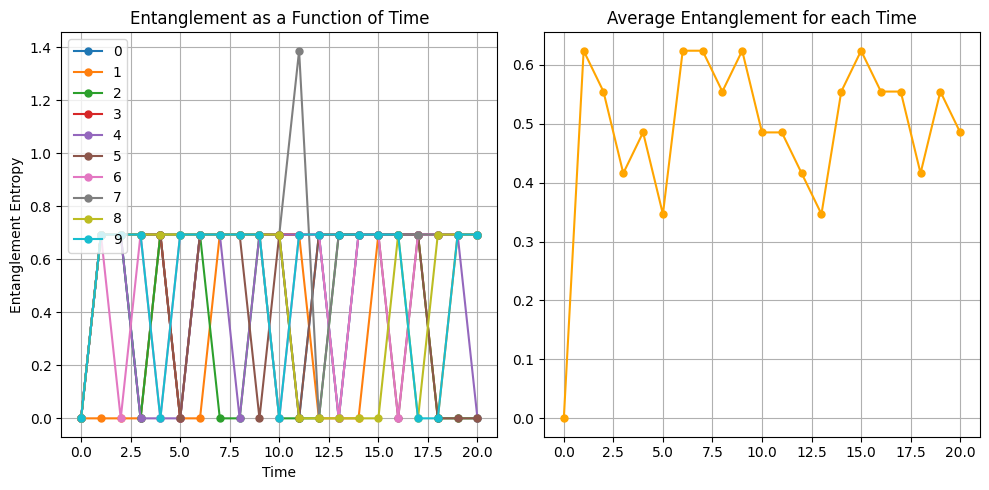

In [ ]:
# same probability, different runs and average.

# System Settings
v = quvec([1,0,1,0,1,1])
# v = quvec([1,0,1,1]) + quvec([1,1,0,0]) + quvec([1,0,0,0])
P = 0.1
runs = 20
div = 2
tests = 10

# plot
plt.figure(figsize=(10, 5))

# plot all data
plt.subplot(1, 2, 1)
Entanglement_sum = np.zeros([runs+1])
time = np.arange(len(Entanglement))
for i in range(0,tests):
    # extract the Data 
    final_state, Entanglement = Z_XX_uniform_probability(v, P, runs, div, evolution=False)
    # print(Entanglement, time)
    plt.plot(time, Entanglement, marker = '.', markersize = 10, label = f'{i}')
    Entanglement_sum += Entanglement

plt.title('Entanglement as a Function of Time')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')

# print(len(time),len(Entanglement_sum))


# average entanglement for each time and plot
Entanglement_avg = Entanglement_sum/tests
plt.subplot(1, 2, 2)
plt.plot(time, Entanglement_avg, marker = '.', markersize = 10, color = 'orange')
# plt.scatter(x_slice, filtered_y, label='Filtered Data',s = 0.8)
plt.title("Average Entanglement for each Time")
# plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# #Save plot as PNG file
# output_file = os.path.join(output_folder, f"{sheet_name}.png")
# plt.savefig(output_file)


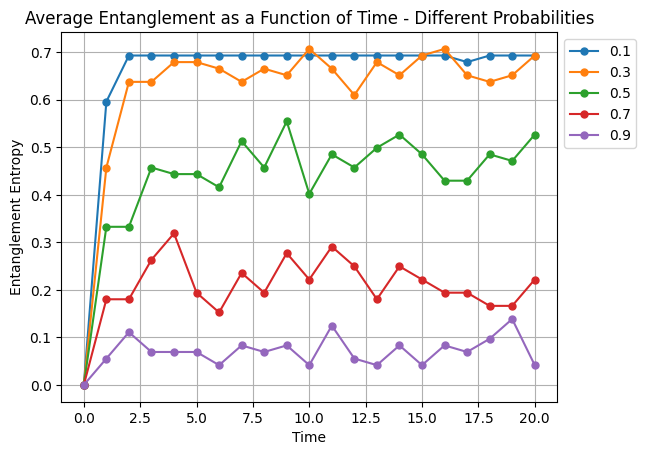

In [42]:
# for different probabilities

# System Settings
v = quvec([1,0,1,0,1,0])
# v = quvec([1,0,1,1]) + quvec([1,1,0,0]) + quvec([1,0,0,0])
P = [0.1,0.3, 0.5,0.7, 0.9]
runs = 20
div = 3
tests = 50 #change name to trajectories

time = np.arange(len(Entanglement))

for p in P:
    Entanglement_sum = np.zeros([runs+1])
    for i in range(0,tests):
        # extract the Data 
        final_state, Entanglement = Z_XX_uniform_probability(v, p, runs, div, evolution=False)
        # print(Entanglement, time)
        # plt.plot(time, Entanglement, marker = '.', markersize = 10, label = f'{i}')
        Entanglement_sum += Entanglement
    Entanglement_avg = Entanglement_sum/tests

    plt.plot(time, Entanglement_avg, marker = '.', markersize = 10, label = f'{p}')


plt.title('Average Entanglement as a Function of Time - Different Probabilities')
# plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Entanglement Entropy')
plt.show()